# Проект: Исследование объявлений о продаже квартир

***


## Исходная информация
**Заказчик**: сервис Яндекс.Недвижимость.  
**Цель проекта**: определить рыночную стоимость объектов недвижимости, установить параметры для автоматизации системы: отслеживание аномалий и мошеннической деятельности.   
**Исходные данные**: данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.

***

## 1 Изучение файла с данными

In [61]:
from io import BytesIO
import requests

import pandas as pd
import matplotlib.pyplot as plt

# импорт файла с исходными данными
spreadsheet_id = '1n3SmsLgo3iC4TgszTsb9Ar2FhcohB1JZmAcwo2EpI8Q'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))
df.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23378,10,3850000.0,46.0,2016-09-01T00:00:00,2,3.00,3.0,29.0,2,False,False,False,5.0,1.0,Санкт-Петербург,22501.0,6446.0,2.0,308.0,3.0,592.0,80.0
18591,20,1350000.0,43.0,2018-10-02T00:00:00,2,2.62,5.0,28.6,5,NaN,False,False,5.0,1.0,Приозерск,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5582,2,4340000.0,37.1,2018-07-02T00:00:00,1,NaN,16.0,14.3,14,NaN,False,False,12.2,1.0,Санкт-Петербург,30201.0,9049.0,0.0,NaN,0.0,NaN,45.0
11965,6,2400000.0,70.0,2018-12-11T00:00:00,3,2.50,5.0,NaN,1,NaN,False,False,8.5,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,41.0
11807,8,5500000.0,79.1,2015-07-08T00:00:00,2,2.60,5.0,47.1,2,NaN,False,False,12.9,1.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,366.0


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Напишем функцию для удобного просмотра основной информации о столбцах таблицы `df`  

In [63]:
def info_column(data):
    nan = {}
    for column in data.columns:
        nan[column] = [data[column].isna().sum(), len(data[column].unique())]
        if (data[column].dtype == 'int64') or (data[column].dtype == 'float64'):
            nan[column] = nan[column] + [data[column].min(), data[column].max(), data[column].median(), data[column].mean()]
        else:
            nan[column] = nan[column] + ['-', '-', '-', '-']  
    
    info_table = pd.DataFrame.from_dict(nan, orient='index')
    info_table.columns = ['nan_number', 'uniques_number', 'min', 'max', 'median', 'mean']
    return info_table.sort_values(by = 'nan_number', ascending = False)

info_column(df)

,nan_number,uniques_number,min,max,median,mean
is_apartment,20924,3,-,-,-,-
parks_nearest,15620,996,1,3190,455,490.805
ponds_nearest,14589,1097,13,1344,502,517.981
balcony,11519,7,0,5,1,1.15008
ceiling_height,9195,184,1,100,2.65,2.7715
airports_nearest,5542,8276,0,84869,26726,28793.7
cityCenters_nearest,5519,7643,181,65968,13098.5,14191.3
ponds_around3000,5518,5,0,3,1,0.770255
parks_around3000,5518,5,0,3,0,0.611408
days_exposition,3181,1142,1,1580,95,180.889


In [64]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

**Выводы:**

* Набор данных состоит из 23699 наблюдений;
* Необходимо проверить таблицу на наличие дублей;
* Проанализировать пропуски и причины их возникновения и при необходимости заполнить их;
* Привести столбцы к удобному типу данных

***

## 2 Предобработка данных 

### 2.1 Проверка на наличие дубликатов

In [65]:
print('Количество дубликатов в таблице:', df.duplicated().sum())

Количество дубликатов в таблице: 0


### 2.2 Обработка пропусков 

***Столбец `is_apartment`*** – апартаменты (булев тип).  
Будем считать, что пропуск в столбце означает, что квартира не является апортаментами.  
Заменим все пропуски на значение `False`.

In [66]:
df['is_apartment'] = df['is_apartment'].fillna(False)

***Столбцы `parks_nearest` и `ponds_nearest`*** – расстояние до ближайшего парка/водоёма.  
Пропуски в датасете скорее всего обусловлены отсутствием парка/водоема поблизости.  
Информация в этих столбцах не особо значима при выборе квартиры. В исходных данных есть столбцы `parks_around3000` и `ponds_around3000`, которых будет достаточно для анализа такого параметра, как наличие парка или водоема поблизости.  
Заменим все пропуски в столбцах `parks_nearest` и `ponds_nearest` на значение `0`.

In [67]:
df['parks_nearest'] = df['parks_nearest'].fillna(0)
df['ponds_nearest'] = df['ponds_nearest'].fillna(0)

***Столбец `balcony`*** – число балконов.  
Будем считать, что пропуск в столбце означает, что балкона в квартире нет.  
Заменим все пропуски на значение 0.  
Так же поступим со столбцами:  
***`airports_nearest`*** – расстояние до ближайшего аэропорта в метрах   
***`ponds_around3000`*** – число водоёмов в радиусе 3 км  
***`parks_around3000`*** – число парков в радиусе 3 км  

In [68]:
df['balcony'] = df['balcony'].fillna(0)
df['airports_nearest'] = df['airports_nearest'].fillna(0)
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)
df['parks_around3000'] = df['parks_around3000'].fillna(0)

***Столбец `floors_total`*** – всего этажей в доме.  
Пустых значений в столбце 86, что составляет 0,3 % от общего количества наблюдений в датасете.  
Заменим пропуск в столбце `floors_total` на значение в столбце `floor`.


In [69]:
df['floors_total'] = df['floors_total'].fillna(df['floor'])

***Столбец `locality_name`*** – название населённого пункта.  
Пустых значений в столбце 49, что составляет 0,2 % от общего количества наблюдений в датасете.  
Заполнить их логически невозможно, поэтому удалим такие строки из таблицы.

In [70]:
df.dropna(subset = ['locality_name'], inplace = True)

<a id="back_to_nan_ceiling_height"></a>

***Столбец `ceiling_height`*** – высота потолков.  
Минимальной нормой в России считается высота потолка 2,4 метра  
В новостройках обычно это значение находится в пределах 2,5-2,7 метра  
Для элитного жилья показатель может превышать 3 метра  
При изучении таблицы в 1-ом пункте проекта посчитали, что медиана по столбцу `ceiling_height`= 2.65, что похоже на правду.  
Заменим отсутствующие значения на медиану.

In [71]:
df['ceiling_height'] = df['ceiling_height'].fillna(0)
df.loc[df['ceiling_height'] == 0, 'ceiling_height'] = df['ceiling_height'].median()

***Столбец `cityCenters_nearest`*** – расстояние до центра города (м).  
Попробуем заменить пропуски на медиану по населенным пунктам.

In [72]:
median_cityCenters_nearest = df.groupby('locality_name').agg({'cityCenters_nearest': 'median'})
median_cityCenters_nearest.loc[median_cityCenters_nearest['cityCenters_nearest'] > 0, 'cityCenters_nearest']

locality_name
Зеленогорск                53381.0
Колпино                    32018.0
Красное Село               29140.5
Кронштадт                  49575.0
Ломоносов                  51677.0
Павловск                   32683.0
Петергоф                   33771.0
Пушкин                     27930.5
Санкт-Петербург            12244.5
Сестрорецк                 34821.0
поселок Лисий Нос          28246.0
поселок Мурино             21888.0
посёлок Александровская    27468.0
посёлок Белоостров         38868.0
посёлок Левашово           25727.0
посёлок Лисий Нос          27297.0
посёлок Металлострой       27602.0
посёлок Молодёжное         65764.0
посёлок Парголово          19311.0
посёлок Песочный           26099.5
посёлок Петро-Славянка     27165.0
посёлок Понтонный          32354.0
посёлок Репино             42896.5
посёлок Сапёрный           35859.5
посёлок Стрельна           23506.0
посёлок Усть-Ижора         28222.5
посёлок Шушары             24212.0
посёлок Щеглово            34085.0
Name: 

При изучении таблицы в 1-ом пункте проекта посчитали, что в столбце `locality_name` 365 уникальных значений. Из полученной таблицы видно, что данных по более чем 300 городах просто нет.  
Заменим пропуски на "маркер" = `100000000000`, чтобы при дальнейшем анализе исключить их, если это будет необходимо.

In [73]:
df['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(100000000000)

***Столбец `days_exposition`*** – сколько дней было размещено объявление (от публикации до снятия).  
Наличие пустых значений означает, что объявление еще не снято с платформы.  
Заменим пропуски на "маркер" = 0 (нулевых значений в таблице нет), чтобы при дальнейшем анализе исключить их, если это будет необходимо

In [74]:
df['days_exposition'] = df['days_exposition'].fillna(0)

***Столбец `living_area`*** – жилая площадь в квадратных метрах(м²)  
Заменим пустые значения по следующему алгоритму:
1. Вычислим коэффициент жилой площади по отношению к общей площади.
2. Заменим все пустые значения в столбце `living_area` на 0.
3. Сгруппируем все объявления в зависимости от количества комнат и посчитаем медиану коэффициента из п.1 для каждой группы.
4. Заменим все нулевые значения в столбце `living_area` на произведение коэф. и столбца `total_area`.

Для начала проверим, есть ли нулевые значения в столбце `rooms`.

In [75]:
df.loc[df['rooms'] == 0, 'rooms'].count()

197

Заменим нулевые значения на 1 (скорее всего, 0 комнат означает, что это квартира студия).

In [76]:
df['rooms'] = df['rooms'].replace(0, 1)

In [77]:
df['coefficient_living_area'] = df['living_area'] / df['total_area']
df['living_area'] = df['living_area'].fillna(0)
 
median_living_area_coefficient = df.groupby('rooms').agg({'coefficient_living_area': 'median'})
 
def living_area(row):
    rooms = row['rooms']
    if row['living_area'] == 0:
        row['living_area'] = row['total_area'] * median_living_area_coefficient.loc[rooms, 'coefficient_living_area']
    return row
 
df = df.apply(living_area, axis = 1)   

***Столбец `kitchen_area`*** – площадь кухни в квадратных метрах (м²)  
С пропусками поступим аналогично методу, примененному к столбцу `living_area`

In [78]:
df['coefficient_kitchen_area'] = df['kitchen_area'] / df['total_area']
df['kitchen_area'] = df['kitchen_area'].fillna(0)

median_kitchen_area_coefficient = df.groupby('rooms').agg({'coefficient_kitchen_area': 'median'})
  
def kitchen_area(row):
    rooms = row['rooms']
    if row['kitchen_area'] == 0:
        row['kitchen_area'] = row['total_area'] * median_kitchen_area_coefficient.loc[rooms, 'coefficient_kitchen_area']
    return row

df = df.apply(kitchen_area, axis = 1)

Проверим, сколько в таблице получилось наблюдений, когда `kitchen_area` + `living_area` > `total_area`

In [79]:
print('Количество ошибочных наблюдений:', df.query('kitchen_area + living_area > total_area').loc[:, 'total_area'].count())
print('Количество наблюдений всего:', df.loc[:, 'total_area'].count())

Количество ошибочных наблюдений: 159
Количество наблюдений всего: 23650


Таких случаев получилось 0,67 %.  
Иключим из таблицы такие значения без искажения итогового результата.

In [80]:
df = df.query('kitchen_area + living_area <= total_area')
df.shape

(23491, 24)

### 2.3 Замена типов данных 

Заменим тип данных в столбцах с дробными значениями на целочисленный для удобства дальнейшего анализа.  
Столбец `ceiling_height` оставим с типом `float64`, так как значения высоты потолка в основном находятся в диапазне `от 2 м до 3 м`, но огруглим до 1 знака просле запятой, чтобы уменьшить количество уникальных значений в столбце.  
Переведем столбец `first_day_exposition` в формат даты.  

In [81]:
df['last_price'] = df['last_price'].astype('int')
df['floors_total'] = df['floors_total'].astype('int')
df['total_area'] = df['total_area'].astype('int')
df['living_area'] = df['living_area'].astype('int')
df['kitchen_area'] = df['kitchen_area'].astype('int')
df['balcony'] = df['balcony'].astype('int')
df['airports_nearest'] = df['airports_nearest'].astype('int')
df['parks_around3000'] = df['parks_around3000'].astype('int')
df['parks_nearest'] = df['parks_nearest'].astype('int')
df['ponds_around3000'] = df['ponds_around3000'].astype('int')
df['ponds_nearest'] = df['ponds_nearest'].astype('int')
df['cityCenters_nearest'] = df['cityCenters_nearest'].astype('int')
df['days_exposition'] = df['days_exposition'].astype('int')
df['ceiling_height'] = df['ceiling_height'].round(1)
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

***

### 2.4 Расчет дополнительных показателей 

Ранее мы посчитали такие показатели, как:
* соотношение жилой и общей площади;
* соотношение площади кухни и общей площади.  

Рассчитаем дополнительно и добавим в таблицу:
* цену квадратного метра;
* день недели, месяц и год публикации объявления;
* этаж квартиры (варианты: первый, последний, другой).

In [82]:
df['price_m2'] = df['last_price'] / df['total_area']
df['price_m2'] = df['price_m2'].astype('int')

df['week_day_of_first_day_exposition'] = pd.DatetimeIndex(df['first_day_exposition']).weekday
df['month_of_first_day_exposition'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['year_of_first_day_exposition'] = pd.DatetimeIndex(df['first_day_exposition']).year

def floor_priority(row):
    if row['floor'] == 1:
        row['floor_priority'] = "первый этаж"
    elif row['floor'] == row['floors_total']:
        row['floor_priority'] = "последний этаж"
    else:
        row['floor_priority'] = "другой"
    return row
df = df.apply(floor_priority, axis = 1)

Переведем значения в столбцах `last_price` и `price_m2` в тыс. руб.

In [83]:
df['last_price'] = df['last_price'] / 1000
df['price_m2'] = df['price_m2'] / 1000
df['last_price'] = df['last_price'].astype('int')
df['price_m2'] = df['price_m2'].astype('int')
df = df.rename(columns = {'last_price': 'last_price_thous', 'price_m2': 'price_m2_thous'})

df.sample(5)

,total_images,last_price_thous,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,coefficient_living_area,coefficient_kitchen_area,price_m2_thous,week_day_of_first_day_exposition,month_of_first_day_exposition,year_of_first_day_exposition,floor_priority
17791,9,23999,90,2017-02-16,2,3.1,8,35,5,False,False,False,20,2,Санкт-Петербург,0,100000000000,0,0,0,0,457,0.398889,0.222222,266,3,2,2017,другой
5013,11,7500,67,2018-01-17,2,2.5,6,35,6,False,False,False,8,0,Санкт-Петербург,27652,9541,0,0,2,437,0,0.522388,0.119403,111,2,1,2018,последний этаж
21601,8,4650,60,2017-11-29,3,2.5,9,37,5,False,False,False,7,0,Санкт-Петербург,50741,16069,0,0,0,0,55,NaN,0.120000,77,2,11,2017,другой
19058,10,2590,50,2019-02-12,2,2.5,5,27,5,False,False,False,8,0,поселок Семрино,0,100000000000,0,0,0,0,0,0.550696,0.170974,51,1,2,2019,последний этаж
4939,8,2990,31,2015-10-30,1,2.5,9,15,6,False,False,False,8,1,Санкт-Петербург,42715,15218,2,334,0,0,618,0.490323,0.267742,96,4,10,2015,другой


***

## 3 Исследовательский анализ данных 

### 3.1 Изучение значений, которые  принимают параметры: высота потолков, площадь, цена, число комнат

* **Высота потолков**

In [84]:
df['ceiling_height'].describe().round(1)

count    23491.0
mean         2.7
std          1.0
min          1.0
25%          2.5
50%          2.5
75%          2.7
max        100.0
Name: ceiling_height, dtype: float64

Построим гистограмму и диаграмму размаха с учетом полученных показателей.  
Максимальное значение (`100 м`) - это явный выброс.  
Первый квартиль равен медиане.  
Основной массив данных сожержит значения `от 2,5 до 2,7 м`

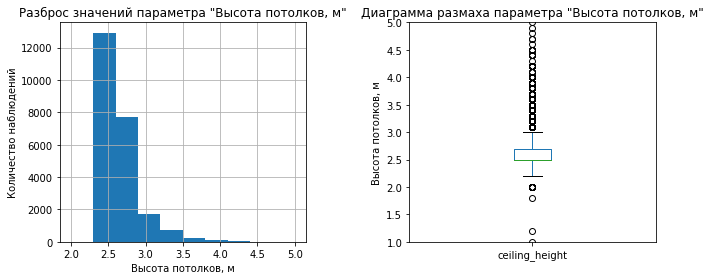

In [85]:
f, ax = plt.subplots(1,2,  figsize = (10, 4))

df.hist('ceiling_height', ax = ax[0], bins = 10, range = (2,5))
ax[0].set_xlabel('Высота потолков, м')
ax[0].set_ylabel('Количество наблюдений')
ax[0].set_title('Разброс значений параметра "Высота потолков, м"')

df['ceiling_height'].plot(kind = 'box', ax = ax[1], ylim = (1, 5), title = 'Диаграмма размаха параметра "Высота потолков, м"')
ax[1].set_ylabel('Высота потолков, м')

f.tight_layout()

**Выводы:**  
* Наиболее часто встречающееся значение высоты потолка = `2.5 м`
* Медиана находится на том же уровне (`2.5 м`)
* Наблюдения, в которых потолок высотой более чем `3 м` и менее чем `2,2`, похожи на выбросы

* **Площадь квартиры, м**

In [86]:
df['total_area'].describe().round(2)

count    23491.00
mean        60.22
std         35.69
min         13.00
25%         40.00
50%         52.00
75%         69.50
max        900.00
Name: total_area, dtype: float64

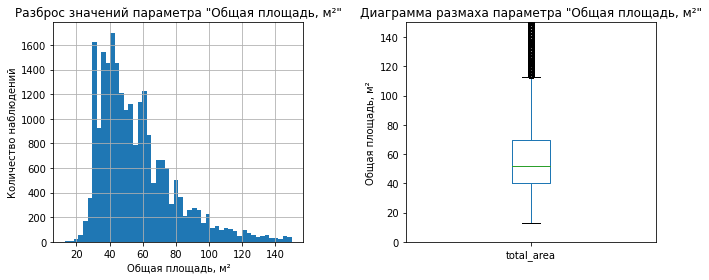

In [87]:
f, ax = plt.subplots(1,2,  figsize = (10, 4))

df.hist('total_area', bins = 50, ax = ax[0], range = (13, 150))
ax[0].set_xlabel('Общая площадь, м²')
ax[0].set_ylabel('Количество наблюдений')
ax[0].set_title('Разброс значений параметра "Общая площадь, м²"')

df['total_area'].plot(kind = 'box', ax = ax[1], ylim = (0, 150), title = 'Диаграмма размаха параметра "Общая площадь, м²"')
ax[1].set_ylabel('Общая площадь, м²')

f.tight_layout()

**Выводы:**  
* Наиболее часто встречающееся значение площади квартиры находится в диапазоне `от 40 м² до 70 м²`
* Медиана находится уровне `52 м²`
* Наблюдения, в которых площадь более чем `115 м²` похожи на выбросы

* **Цена на квартиру, тыс. руб.**

In [88]:
df['last_price_thous'].describe().round(2)

count     23491.00
mean       6544.24
std       10881.53
min          12.00
25%        3440.00
50%        4650.00
75%        6800.00
max      763000.00
Name: last_price_thous, dtype: float64

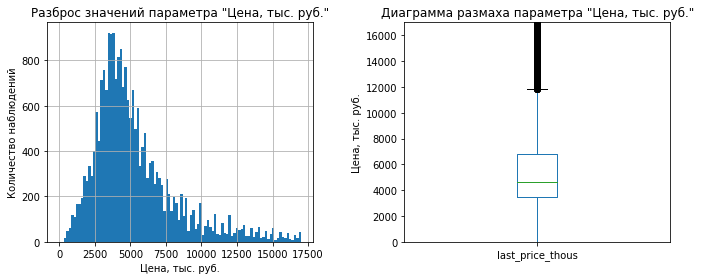

In [89]:
f, ax = plt.subplots(1,2,  figsize = (10, 4))

df.hist('last_price_thous', bins = 100, ax = ax[0], range = (0, 17000))
ax[0].set_xlabel('Цена, тыс. руб.')
ax[0].set_ylabel('Количество наблюдений')
ax[0].set_title('Разброс значений параметра "Цена, тыс. руб."')

df['last_price_thous'].plot(kind = 'box', ax = ax[1], ylim = (0, 17000), title = 'Диаграмма размаха параметра "Цена, тыс. руб."')
ax[1].set_ylabel('Цена, тыс. руб.')

f.tight_layout()

**Выводы:**  
* Наиболее часто встречающееся значение цены находится в диапазоне `от 3,5 млн до 7 млн`
* Медиана находится на уровне `4,6 млн`
* Наблюдения, в которых цена более чем `12 млн`  похожи на выбросы

* **Количество комнат**

In [90]:
df['rooms'].describe().round(2)

count    23491.00
mean         2.08
std          1.07
min          1.00
25%          1.00
50%          2.00
75%          3.00
max         19.00
Name: rooms, dtype: float64

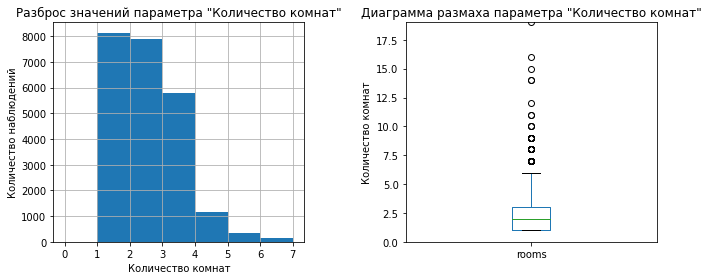

In [91]:
f, ax = plt.subplots(1,2,  figsize = (10, 4))

df.hist('rooms', bins = 7, ax = ax[0], range = (0, 7))
ax[0].set_xlabel('Количество комнат')
ax[0].set_ylabel('Количество наблюдений')
ax[0].set_title('Разброс значений параметра "Количество комнат"')

df['rooms'].plot(kind = 'box', ax = ax[1], ylim = (0, 19), title = 'Диаграмма размаха параметра "Количество комнат"')
ax[1].set_ylabel('Количество комнат')

f.tight_layout()

**Выводы:**  
* Наиболее часто встречающиеся значения количества комнат - это `1 и 2`
* Медиана находится на уровне `2 комнат`
* Наблюдения, в которых комнат более чем `6`, похожи на выбросы

### 3.2 Изучение времени продажи квартиры



Изучим время продажи квартиры.   
На этапе обработки пропусков мы заменили пропущенные значения в столбце `days_exposition` на маркер `0`.  
Для дальнейшего анализа создадим таблицу, в которую будут включены только очищенные от выбросов данные.

In [92]:
good_table = df.query('days_exposition > 0').copy()
good_table['days_exposition'].describe().round(2)

count    20327.00
mean       181.04
std        220.02
min          1.00
25%         45.00
50%         95.00
75%        232.00
max       1580.00
Name: days_exposition, dtype: float64

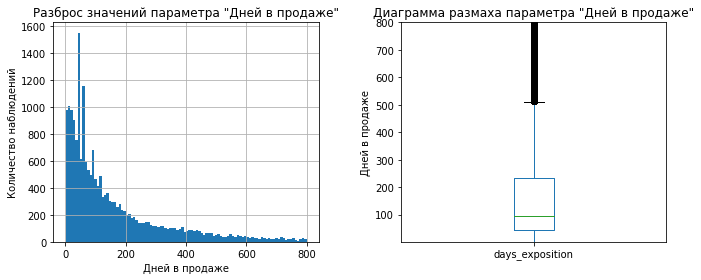

In [93]:
f, ax = plt.subplots(1,2,  figsize = (10, 4))

good_table.hist('days_exposition', bins = 100, ax = ax[0], range = (1, 800))
ax[0].set_xlabel('Дней в продаже')
ax[0].set_ylabel('Количество наблюдений')
ax[0].set_title('Разброс значений параметра "Дней в продаже"')

good_table['days_exposition'].plot(kind = 'box', ax = ax[1], ylim = (1, 800), title = 'Диаграмма размаха параметра "Дней в продаже"')
ax[1].set_ylabel('Дней в продаже')

f.tight_layout()

**Выводы:**  
* Продажа квартиры обычно занимает `от 45 до 240 дней`.
* Медиана находтся на уровне `95 дней (~3 месяцев)`
* Cреднее значение (`181 день`) в 2 раза больше медианы. Это говорит о том, что в выборке довольно длинный хвост высоких значений (что мы и видим на гистограмме), влияющий на среднее значние, но не на медиану.
* Сделку можно считать очень быстрой, если она завершилась менее чем за 45 дней, и слишком долгой, если она состоялась только после `230 дней` после размещения объявления.

### 3.3 Изучение редких и выбивающихся значений

Изучим редкие и выбивающиеся знаечния в столбцах:
1. Высота потолков (м)
3. Площадь квартиры в квадратных метрах (м²)
2. Цена на момент снятия с публикации
4. Число комнат

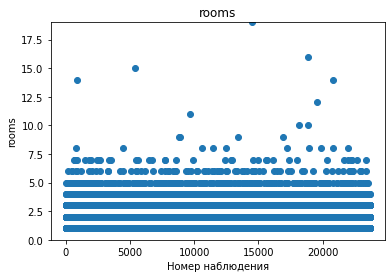

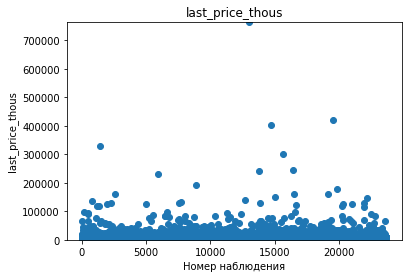

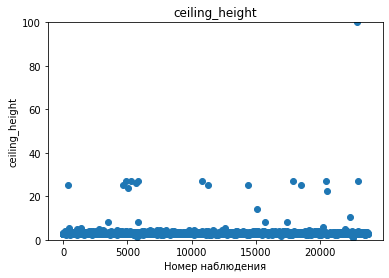

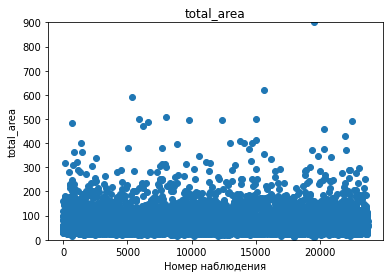

{'ceiling_height': [100.0],
 'last_price_thous': [763000],
 'rooms': [19],
 'total_area': [900]}

In [94]:
dict_for_auto = {
    'rooms' : [good_table['rooms'].max()],
    'last_price_thous' : [good_table['last_price_thous'].max()],
    'ceiling_height' : [good_table['ceiling_height'].max()],
    'total_area' : [good_table['total_area'].max()]
}
 
for column in dict_for_auto:
    good_table[column].plot(style = 'o')
    plt.title(column)
    plt.ylim((0, dict_for_auto[column][0]))
    plt.xlabel('Номер наблюдения')
    plt.ylabel(column)
    plt.show()
    
dict_for_auto

Обработаем дополнительно выбросы в столбце **Высота потолков**   
Минимальной нормой в России считается высота потолка `2,4 метра`  
В новостройках обычно это значение находится в пределах `2,5-2,7 метра`  
Для элитного жилья показатель может превышать `3 метра`  

На нашем графике основная масса наблюдений расположена на уровне от 0 до ~ 10 м.  
Значение `100` явно является выбросом.  
Наблюдается несколько предполагаемых выбросов в диапазоне `от 20 м до 40 м`. Видно, что эти значения колеблются в большей степени на уровне 25 метров. Можно предположить, что в них ошибочно не проставлена запятая как разделитель десятичного числа.  
Проверим эту гипотезу: изучим значение столбца `total_area` в таких наблюдениях.

In [95]:
good_table.query('ceiling_height >= 10 ').sort_values(by='total_area')

,total_images,last_price_thous,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,coefficient_living_area,coefficient_kitchen_area,price_m2_thous,week_day_of_first_day_exposition,month_of_first_day_exposition,year_of_first_day_exposition,floor_priority
4876,7,3000,25,2017-09-27,1,27.0,25,17,17,False,False,True,6,2,посёлок Мурино,0,100000000000,0,0,0,0,28,0.680000,NaN,120,2,9,2017,другой
22869,0,15000,25,2018-07-25,1,100.0,5,14,5,True,False,False,11,5,Санкт-Петербург,34963,8283,1,223,3,30,19,0.560000,0.440000,600,2,7,2018,последний этаж
5076,0,3850,30,2018-10-03,1,24.0,5,19,1,True,False,False,5,0,Санкт-Петербург,29686,8389,3,397,1,578,7,0.639344,0.180328,128,2,10,2018,первый этаж
14382,9,1700,35,2015-12-04,1,25.0,5,20,2,False,False,False,8,1,поселок Новый Свет,0,100000000000,0,0,0,0,206,0.571429,0.228571,48,4,12,2015,другой
11285,0,1950,37,2019-03-20,1,25.0,5,17,4,False,False,False,9,2,Луга,0,100000000000,0,0,0,0,18,0.459459,0.243243,52,2,3,2019,другой
18545,6,3750,43,2019-03-18,2,25.0,5,29,3,False,False,False,6,0,Санкт-Петербург,27054,8033,1,540,0,0,12,0.674419,NaN,87,0,3,2019,другой
4643,0,4300,45,2018-02-01,2,25.0,9,30,2,False,False,False,7,1,Санкт-Петербург,12016,13256,1,658,1,331,181,0.666667,0.155556,95,3,2,2018,другой
22309,20,5300,45,2017-09-30,1,10.3,16,15,15,False,False,False,11,0,Санкт-Петербург,36353,11936,2,440,2,450,136,0.344444,NaN,117,5,9,2017,другой
20478,11,8000,45,2017-07-18,1,27.0,4,22,2,False,False,False,10,1,Санкт-Петербург,18975,3246,0,0,3,449,429,0.488889,0.222222,177,1,7,2017,другой
5669,4,4400,50,2017-08-08,2,26.0,9,21,3,False,False,False,7,2,Санкт-Петербург,28981,10912,1,305,0,0,267,0.426000,0.140000,88,1,8,2017,другой


Из таблицы видно, что значения все-таки не являются выбросами: внесенные данные являются ошибочными (площадь по квартирам в диапазоне от 25 м² до 98 м², а количество комнат максимум 4).  
Предлагается:
* Значения в диапазоне от 20 м условно разделить на 10, тем самым возвращая на место пропущенную запятую;
* Значения >= 10 м заменим на медианное по всем наблюдениям. На этом шаге исключится выброс в 100 м (после первого действия он станет 10 м).

Медианное значение после 1-ого преобразования: 2.5
Максимальная высота потолков после 1-ого преобразования  8.3 м
Минимальная высота потолков после 1-ого преобразования  1.0 м


Text(0, 0.5, 'Высота потолков, м')

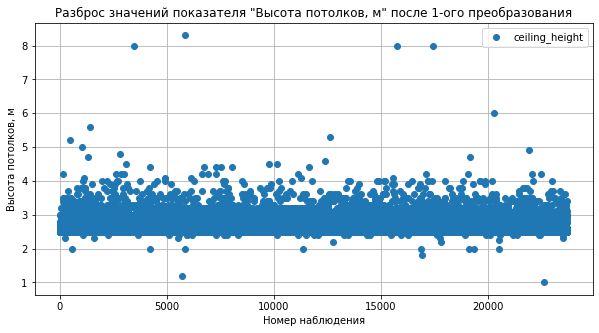

In [96]:
good_table.loc[good_table['ceiling_height'] >= 20, 'ceiling_height'] = good_table['ceiling_height'] / 10
good_table.loc[good_table['ceiling_height'] >= 10, 'ceiling_height'] = good_table.loc[good_table['ceiling_height'] > 0, 'ceiling_height'].median()
print('Медианное значение после 1-ого преобразования:',good_table.loc[good_table['ceiling_height'] > 0, 'ceiling_height'].median())
print('Максимальная высота потолков после 1-ого преобразования ', good_table['ceiling_height'].max(), 'м')
print('Минимальная высота потолков после 1-ого преобразования ', good_table['ceiling_height'].min(), 'м')
good_table.plot(y = 'ceiling_height', 
                style = 'o', 
                grid = True, 
                figsize = (10,5), 
                title = 'Разброс значений показателя "Высота потолков, м" после 1-ого преобразования')
plt.xlabel('Номер наблюдения')
plt.ylabel('Высота потолков, м')

После преобразования слишком больших значений стала лучше видна картина внизу.  
Можно заметить, что квартир с подозрительной высотой потолков (`выше 5 м`) не так много. Эти значения следует так же заменить на медиану.  
На графике так же видно, что в данных присутствуют подозрительно малые и нулевые значения показателя (`< 2 м`). С ними поступим аналогично.

Медианное значение после 2-ого преобразования: 2.5
Максимальная высота потолков после 2-ого преобразования  4.9 м
Минимальная высота потолков после 2-ого преобразования  2.2 м


Text(0, 0.5, 'Высота потолков, м')

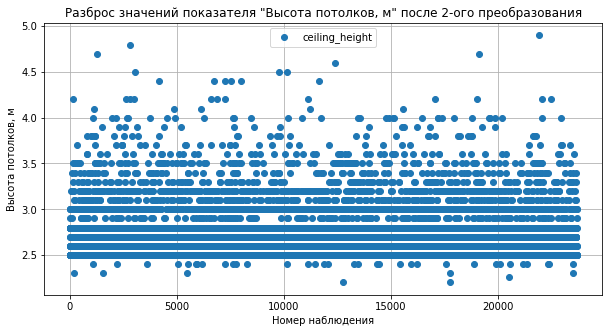

In [97]:
good_table.loc[good_table['ceiling_height'] >= 5, 'ceiling_height'] = good_table.loc[df['ceiling_height'] > 0, 'ceiling_height'].median()
good_table.loc[good_table['ceiling_height'] <= 2, 'ceiling_height'] = good_table.loc[df['ceiling_height'] > 0, 'ceiling_height'].median()
print('Медианное значение после 2-ого преобразования:',good_table['ceiling_height'].median())
print('Максимальная высота потолков после 2-ого преобразования ', good_table['ceiling_height'].max(), 'м')
print('Минимальная высота потолков после 2-ого преобразования ', good_table['ceiling_height'].min(), 'м')
good_table.plot(y = 'ceiling_height', 
        style = 'o', 
        grid = True, 
        figsize = (10,5), 
        title = 'Разброс значений показателя "Высота потолков, м" после 2-ого преобразования')
plt.xlabel('Номер наблюдения')
plt.ylabel('Высота потолков, м')

Теперь разброс данных выглядит правдоподобно: основная масса квартир с высостой потолков от 2,5 м до 3 м.

Отфильтруем таблицу `good_table` по анализируемым столбцам в зависимости от значений "усов".  
Создадим словарь со значениями верхнего и нижнего "уса" для каждого столбца.

In [98]:
dict_emission_remover = ['rooms', 'last_price_thous',
                         'ceiling_height', 'total_area']
 
whiskers_dict = dict()
 
for column_name in dict_emission_remover: 
    quantiles = good_table[column_name].quantile([0.25, 0.75])
    iqr = quantiles.iloc[1] - quantiles.iloc[0]
    lowest_point = max(0, quantiles.iloc[0] - 1.5 * iqr)
    highest_point = quantiles.iloc[1] + 1.5 * iqr
    whiskers_dict[column_name] = [lowest_point, highest_point]
    
whiskers_dict

{'ceiling_height': [2.1999999999999997, 3.0000000000000004],
 'last_price_thous': [0, 11150.0],
 'rooms': [0, 6.0],
 'total_area': [0, 109.0]}

Отфильтруем столбцы таблицы `good_table` по значениям верхнего и нижнего уса. 

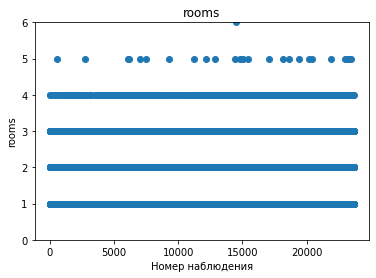

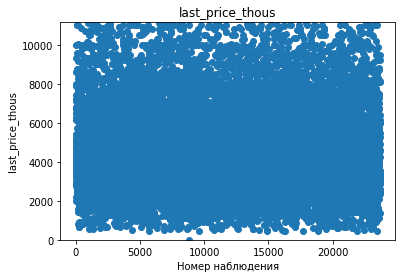

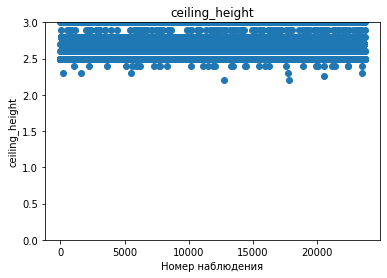

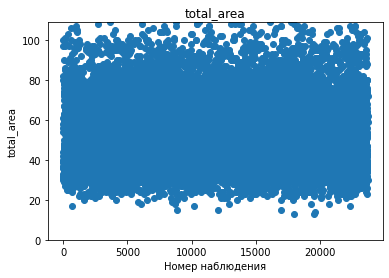

In [99]:
good_table = good_table[(good_table['rooms'] > whiskers_dict['rooms'][0]) 
                       & (good_table['rooms'] <= whiskers_dict['rooms'][1])
                       & (good_table['last_price_thous'] > whiskers_dict['last_price_thous'][0]) 
                       & (good_table['last_price_thous'] <= whiskers_dict['last_price_thous'][1])
                       & (good_table['ceiling_height'] >= whiskers_dict['ceiling_height'][0]) 
                       & (good_table['ceiling_height'] <= whiskers_dict['ceiling_height'][1])
                       & (good_table['total_area'] > whiskers_dict['total_area'][0]) 
                       & (good_table['total_area'] <= whiskers_dict['total_area'][1])]
dict_for_auto = {
    'rooms' : [good_table['rooms'].max()],
    'last_price_thous' : [good_table['last_price_thous'].max()],
    'ceiling_height' : [good_table['ceiling_height'].max()],
    'total_area' : [good_table['total_area'].max()]
}
for column in dict_for_auto:
    good_table[column].plot(style = 'o')
    plt.title(column)
    plt.ylim((0, dict_for_auto[column][0]))
    plt.xlabel('Номер наблюдения')
    plt.ylabel(column)
    plt.show()

В таблице `good_table` остались наблюднения с типовыми значениями без пропусков и выбросов.

### 3.4 Изучение факторов, влияющих на стоимость квартиры

Проанализируем, как указанные ниже параметры влияют на показатель `last_price_thous`:
* Площадь квартиры
* Количество комнат
* Этаж (первый, последний, другой)
* Удаленность квартиры от центра
* Дата размещения объявления (день недели, месяц, год)

Коэффициент корреляции: 0.68


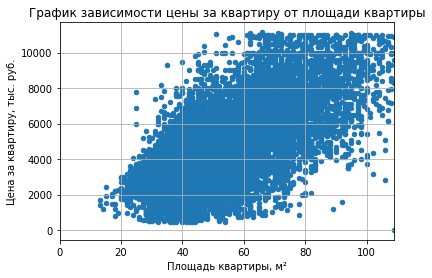

In [100]:
good_table.plot(x = 'total_area', y = 'last_price_thous', kind='scatter', grid = True) 
plt.title('График зависимости цены за квартиру от площади квартиры')
plt.xlim((0, good_table['total_area'].max()))
plt.ylabel('Цена за квартиру, тыс. руб.')
plt.xlabel('Площадь квартиры, м²')
print('Коэффициент корреляции:', good_table['last_price_thous'].corr(good_table['total_area']).round(2))

**Вывод**: корреляция в 0,68 говорит о наличии связи: чем больше площадь квартиры, тем выше ее стоимость.   
На графике видны несколько значений с площадью квартиры более 80 и ценой квартиры менее 4000 тыс. руб., которые либо являются выбросами, либо это квартиры сильно удаленные от центра, например.

Коэффициент корреляции: 0.41


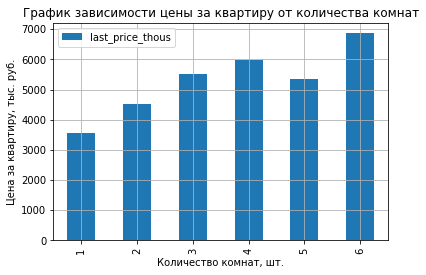

In [101]:
good_table_rooms = good_table.pivot_table(index='rooms', values='last_price_thous', aggfunc='median')
good_table_rooms.plot(y = 'last_price_thous', kind = 'bar', grid = True) 
plt.title('График зависимости цены за квартиру от количества комнат')
plt.ylabel('Цена за квартиру, тыс. руб.')
plt.xlabel('Количество комнат, шт.')
print('Коэффициент корреляции:', good_table['last_price_thous'].corr(good_table['rooms']).round(2))

**Вывод**: корреляция в 0,41 говорит о слабой связи между количеством комнат и ценой на квартиру.   
На графике можно заметить, что медианная цена на квартиры растет вместе с увеличением комнат в них, однако в случае с 5-ю комнатами этого сказать нельзя.

Text(0.5, 0, 'Этаж')

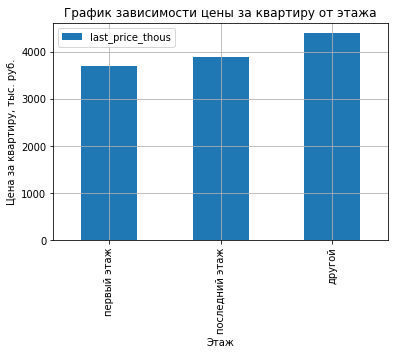

In [102]:
good_table_floor = good_table.pivot_table(index='floor_priority', values='last_price_thous', aggfunc='median')
good_table_floor.sort_values(by = 'last_price_thous').plot(y = 'last_price_thous', kind = 'bar', grid = True) 
plt.title('График зависимости цены за квартиру от этажа')
plt.ylabel('Цена за квартиру, тыс. руб.')
plt.xlabel('Этаж')

**Вывод**: На графике можно заметить, что квартиры на первом этаже обычно дешевле, чем на других этажах. Квартиры `не` на первом и `не` на последнем этаже обычно дороже.

Коэффициент корреляции: -0.48


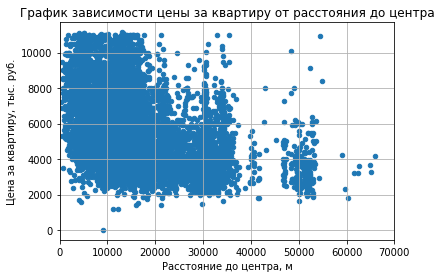

In [103]:
good_table.plot(x = 'cityCenters_nearest', y = 'last_price_thous', kind='scatter', grid = True) 
plt.title('График зависимости цены за квартиру от расстояния до центра')
plt.xlim((0, 70000))
plt.ylabel('Цена за квартиру, тыс. руб.')
plt.xlabel('Расстояние до центра, м')
print('Коэффициент корреляции:', good_table['last_price_thous'].corr(good_table['cityCenters_nearest']).round(2))

**Вывод**: Отрицательный показатель коэффициента корреляции говорит об обратной зависимости: чем больше расстояние квартиры до центра города, тем меньше ее стоимость. Коэффициент равен -0,48, это говорит о слабой связи между двумя параметрами.  
На графике можно заметить, что почти нет четкой линейной связи в имеющемся наборе данных

Text(0.5, 0, 'День недели')

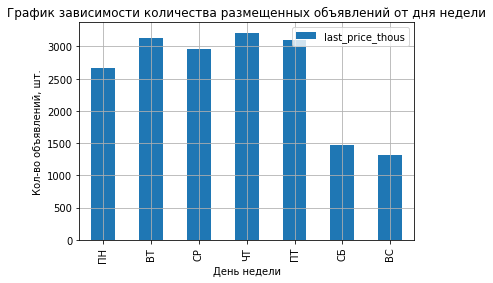

In [104]:
good_table_week_day = good_table.pivot_table(index='week_day_of_first_day_exposition', values='last_price_thous', aggfunc='count')
good_table_week_day.sort_values(by = 'week_day_of_first_day_exposition').rename({0: 'ПН', 1: 'ВТ', 2: 'СР', 3: 'ЧТ', 4: 'ПТ', 5: 'СБ', 6: 'ВС'}, axis='index').plot(y = 'last_price_thous', kind = 'bar', grid = True) 
plt.title('График зависимости количества размещенных объявлений от дня недели')
plt.ylabel('Кол-во объявлений, шт.')
plt.xlabel('День недели')

**Вывод**: на диаграмме можно заметить, что в основном объявления размещаются в будние дни, в выходные наблюдается значительный спад. 

Text(0.5, 0, 'Месяц')

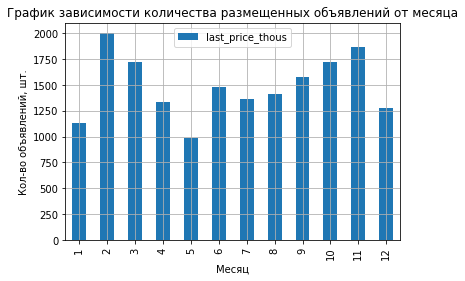

In [105]:
good_table_month = good_table.pivot_table(index='month_of_first_day_exposition', values='last_price_thous', aggfunc='count')
good_table_month.sort_values(by = 'month_of_first_day_exposition').plot(y = 'last_price_thous', kind = 'bar', grid = True) 
plt.title('График зависимости количества размещенных объявлений от месяца')
plt.ylabel('Кол-во объявлений, шт.')
plt.xlabel('Месяц')

**Вывод**: на диаграмме видим, что чаще всего объявления размещаются к концу зимы (февраль), однако к маю наблюдается спад. Начиная с августа наблюдается равномерный рост количества объявлений, который оканчивается в ноябре (в декабре-январе наблюдается спад)

15427   2014-11-27
8393    2014-11-27
20635   2014-11-27
19352   2014-11-29
12875   2014-12-04
           ...    
94      2019-04-26
13061   2019-04-29
16212   2019-04-30
16053   2019-04-30
1632    2019-05-01
Name: first_day_exposition, Length: 17868, dtype: datetime64[ns]

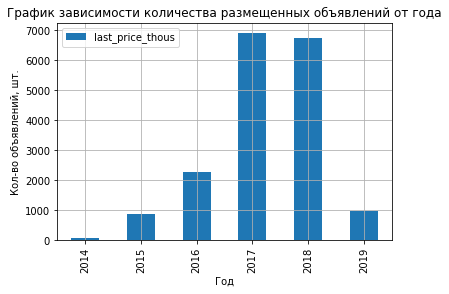

In [106]:
good_table_year = good_table.pivot_table(index='year_of_first_day_exposition', values='last_price_thous', aggfunc='count')
good_table_year.sort_values(by = 'year_of_first_day_exposition').plot(y = 'last_price_thous', kind = 'bar', grid = True) 
plt.title('График зависимости количества размещенных объявлений от года')
plt.ylabel('Кол-во объявлений, шт.')
plt.xlabel('Год')
good_table.sort_values(by = 'first_day_exposition').loc[:, 'first_day_exposition']

**Вывод**: на данном графике можно увидеть только то, что основной массив предоставленных данных относится к 2017-2018 гг.

### 3.5 Изучение ТОП-10 населённых пунктов с наибольшим числом объявлений

Посчитаем среднюю цену квадратного метра в ТОП-10 населённых пунктах. Выделим населённые пункты с самой высокой и низкой стоимостью жилья.

In [109]:
good_table_locality_name = good_table.pivot_table(index='locality_name', 
                                                  values='price_m2_thous', 
                                                  aggfunc={'price_m2_thous':['count', 'mean']})
good_table_top10_price_m2_thous = good_table_locality_name.sort_values(by = 'count', ascending = False).head(10)
good_table_top10_price_m2_thous = good_table_top10_price_m2_thous.rename(columns = {'count': 'Количество объявлений', 
                                                                                    'mean': 'Средняя цена за м²'})
good_table_top10_price_m2_thous.sort_values(by = 'Средняя цена за м²', ascending = False)

,Количество объявлений,Средняя цена за м²
locality_name,,
Санкт-Петербург,11252.0,103.774796
Пушкин,276.0,99.438406
деревня Кудрово,294.0,92.455782
посёлок Парголово,299.0,89.785953
посёлок Мурино,502.0,85.637450
посёлок Шушары,399.0,77.829574
Колпино,296.0,74.668919
Гатчина,259.0,67.749035
Всеволожск,327.0,66.510703


**Вывод**: Самые дорогие квартиры находятся в след. населенных пунктах: Санкт-Петербург, Пушкин, деревня Кудрово, посёлок Парголово, посёлок Мурино.  
Наиболее низкая стоимость: Выборг, Всеволожск, Гатчина, Колпино, посёлок Шушары.	

### 3.6 Изучение квартир в Санкт-Петербурге



Изучим предложение квартир в Санкт-Петербурге: выясним, какая область входит в центр Питера.  
Создадим столбец с расстоянием до центра в километрах: округлим до целых значений. После этого посчитаем среднюю цену для каждого километра. Построим график: он будет показывать, как цена зависит от удалённости от центра.

In [110]:
good_table_Piter = good_table.query('locality_name == "Санкт-Петербург"').copy()
good_table_Piter['cityCenters_nearest_km'] = good_table_Piter['cityCenters_nearest'] / 1000
good_table_Piter['cityCenters_nearest_km'] = good_table_Piter['cityCenters_nearest_km'].round()
good_table_Piter['cityCenters_nearest_km'] = good_table_Piter['cityCenters_nearest_km'].replace(0, 1)
good_table_Piter['price_for_km'] = good_table_Piter['price_m2_thous'] / good_table_Piter['cityCenters_nearest_km']
good_table_Piter['price_for_km'] = good_table_Piter['price_for_km'].astype('int')
good_table_Piter['cityCenters_nearest_km'] = good_table_Piter['cityCenters_nearest_km'].astype('int')
good_table_Piter_km = good_table_Piter.pivot_table(index='cityCenters_nearest_km', values='price_for_km', aggfunc='mean')

Text(0.5, 0, 'Удаленность от центра, км')

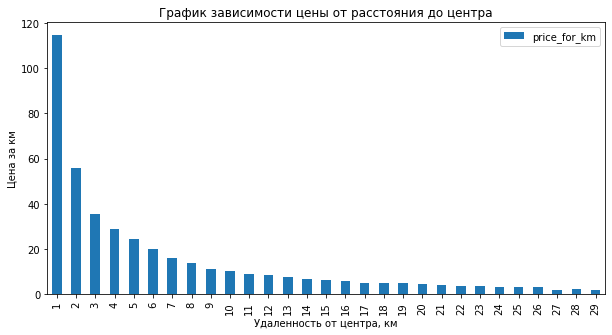

In [111]:
good_table_Piter_km.query('cityCenters_nearest_km < 30').plot(kind = 'bar', figsize = (10,5))
plt.title('График зависимости цены от расстояния до центра')
plt.ylabel('Цена за км')
plt.xlabel('Удаленность от центра, км')

**Вывод**: на графике четко видна зависимость цены от квартиры от ее удаленности от центра: по мере удаленности цена на кв падает.  
Можно выделить границу центра в Питере: до расстояния от центра равного 8 км наблюдается равномерный спад, после 8 км наблюдается "ступенька", которая и является границей центра города.

### 3.7 Анализ центрального района Санкт-Петербурга и других районов


Выделим сегмент квартир в центре. Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков. Также выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). 

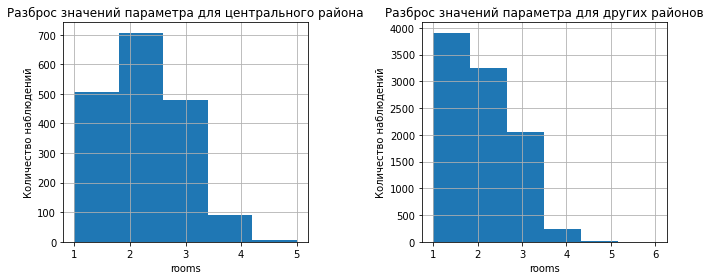

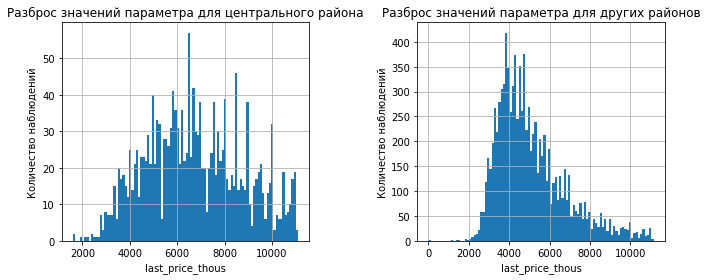

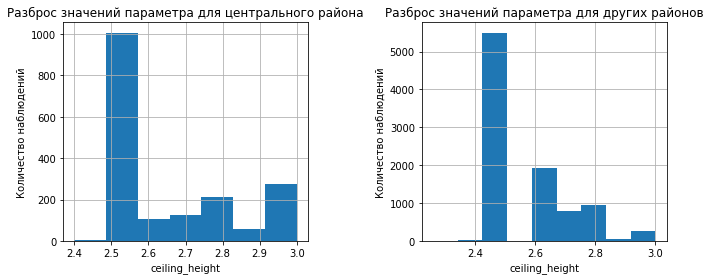

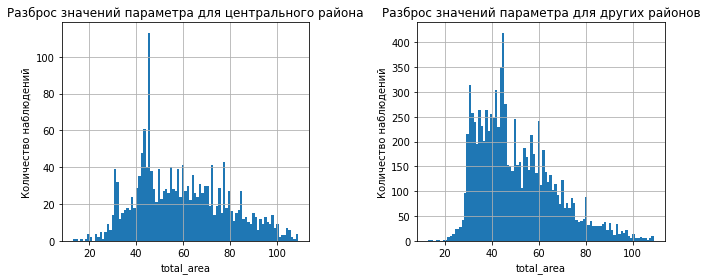

In [53]:
def center(row):
    if row['cityCenters_nearest_km'] <= 8:
        row['center'] = 1
    else:
        row['center'] = 0
    return row
good_table_Piter = good_table_Piter.apply(center, axis = 1)

dict_for_auto_Piter = dict()
 
for column_name in dict_emission_remover: 
    lowest_point_center = good_table_Piter.query('center == 1')[column_name].min()
    highest_point_center = good_table_Piter.query('center == 1')[column_name].max()
    unique_center = len(good_table_Piter.query('center == 1')[column_name].unique())
    lowest_point_other = good_table_Piter.query('center == 0')[column_name].min()
    highest_point_other = good_table_Piter.query('center == 0')[column_name].max()
    unique_other = len(good_table_Piter.query('center == 0')[column_name].unique())
    dict_for_auto_Piter[column_name] = [lowest_point_center, highest_point_center, unique_center, lowest_point_other, highest_point_other, unique_other]    
    
for column in dict_for_auto_Piter:
    f, ax = plt.subplots(1,2,  figsize = (10,4))
    good_table_Piter.query('center == 1').hist(column, ax = ax[0], bins = min(100, dict_for_auto_Piter[column][2]), range = (dict_for_auto_Piter[column][0], dict_for_auto_Piter[column][1]))
    ax[0].set_title('Разброс значений параметра для центрального района')
    ax[0].set_ylabel('Количество наблюдений')
    ax[0].set_xlabel(column)

    good_table_Piter.query('center == 0').hist(column, ax = ax[1],bins = min(100, dict_for_auto_Piter[column][5]), range = (dict_for_auto_Piter[column][3], dict_for_auto_Piter[column][4]))
    ax[1].set_title('Разброс значений параметра для других районов')
    ax[1].set_ylabel('Количество наблюдений')
    ax[1].set_xlabel(column)

    f.tight_layout()

**Вывод:**
* Сравнивая показатель количество комнат в центральном районе и в других районах Питера, можно заметить, что преобладающее количество квартир имеют 1 или 2 комнаты (в центральном районе больше всего двухкомнатных квартир).
* Показатель цены на квартиру значительно отличается в центральном и других районах Питера: на графике центрального района можно заметить значительный разброс цен в диапазоне от 4,5 млн руб. до 9 млн руб., на графике других районов большая часть квартир имеет цену от 2,5 млн руб. до 6 млн руб.
* Графики по показателю высота потолков в центральном и других районах имеют примерно одинаковый вид: преобладает высота, равная 2,5 м
* Вывод по показателю общая площадь квартиры схож с выводом по показателю цена за квартиру: на графике центрального района значительный разброс площади в диапазоне от 40 м2 до 85 м2, на графике других районов большая часть квартир имеет площадь от 30 м2 до 60 м2

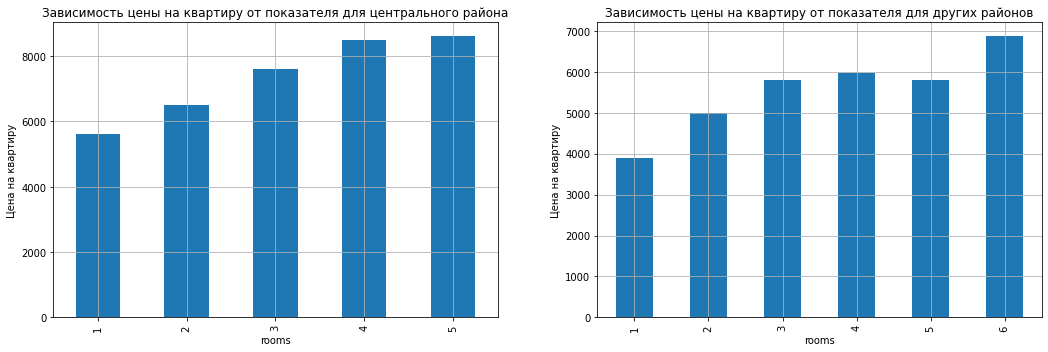

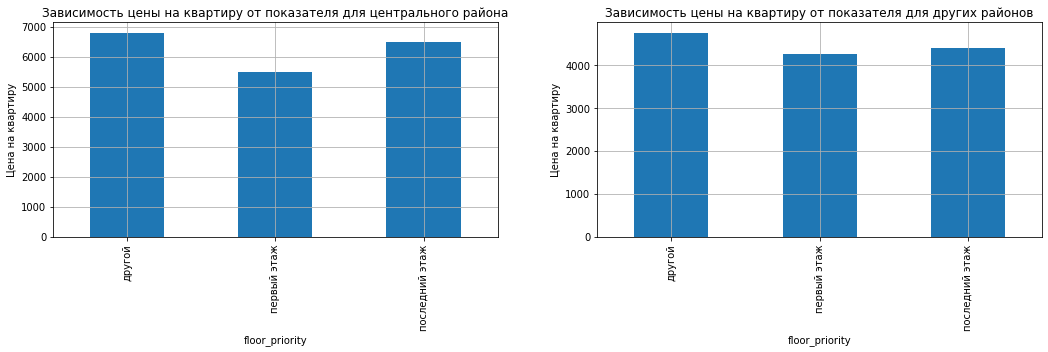

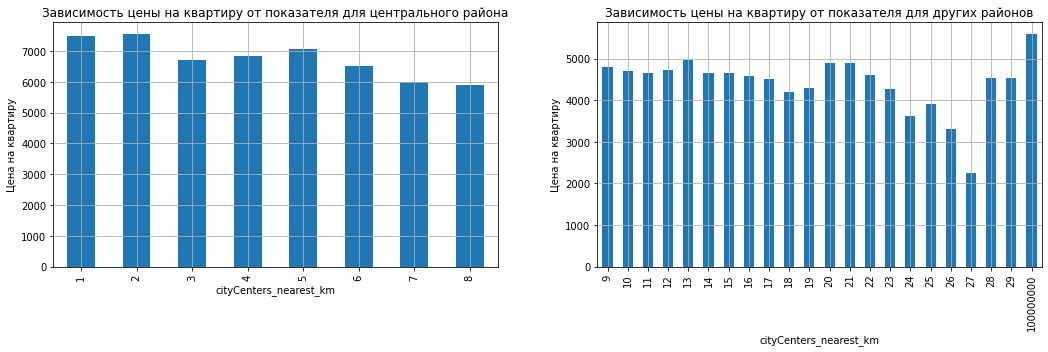

In [54]:
dict_corr = ['rooms', 
             'floor_priority',
             'cityCenters_nearest_km']

for column in dict_corr:
    f, ax = plt.subplots(1,2,  figsize = (15,5))
    pivot_table = good_table_Piter.query('center == 1').pivot_table(index=column, values='last_price_thous', aggfunc='median')
    pivot_table.plot(ax = ax[0], y = 'last_price_thous', legend = False, kind = 'bar', grid = True)
    ax[0].set_title('Зависимость цены на квартиру от показателя для центрального района')
    ax[0].set_ylabel('Цена на квартиру')
    ax[0].set_xlabel(column)
    
    pivot_table = good_table_Piter.query('center == 0').pivot_table(index=column, values='last_price_thous', aggfunc='median')
    pivot_table.plot(ax = ax[1], y = 'last_price_thous', legend = False, kind = 'bar', grid = True)
    ax[1].set_title('Зависимость цены на квартиру от показателя для других районов')
    ax[1].set_ylabel('Цена на квартиру')
    ax[1].set_xlabel(column)
    
    f.tight_layout()

**Вывод:**
* И в центральном, и в других районах Питера существует зависимость: чем больше комнат в квартире, тем дороже ее стоимость.
* Что касается зависимости цены на квартиру от этажа: и в центральном, и в других районах квартиры на 1-ом этаже обычно стоят дешевле, чем на других этажах. В целом, можно сказать, что квартиры `не` на первом этаже стоят примерно одинаково (но квартиры на последнем этаже немного дешевле, чем на другом).
* Зависимость между расстоянием до центра и ценой на квартиру можно описать так: чем дальше квартира от центра, тем она дешевле. Но есть некоторые "выбросы": например, на графике центра Питера видно резкое снижение цен на расстоянии 3-4 км, далее график постепенно снижается. На графике других районов присутствуют те же моменты: на расстоянии 13, 20-22, 28-29 км цены значительно выбиваются из общей тенденции.

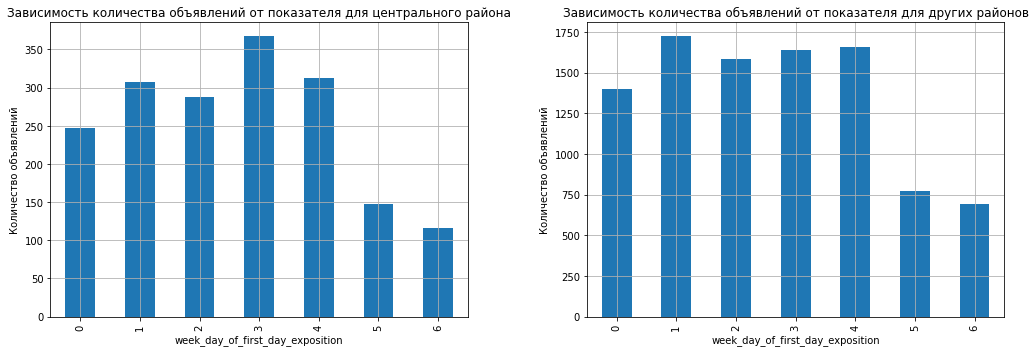

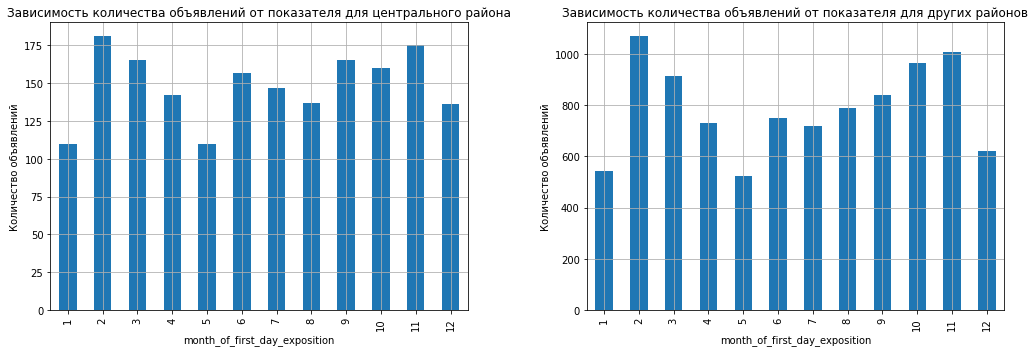

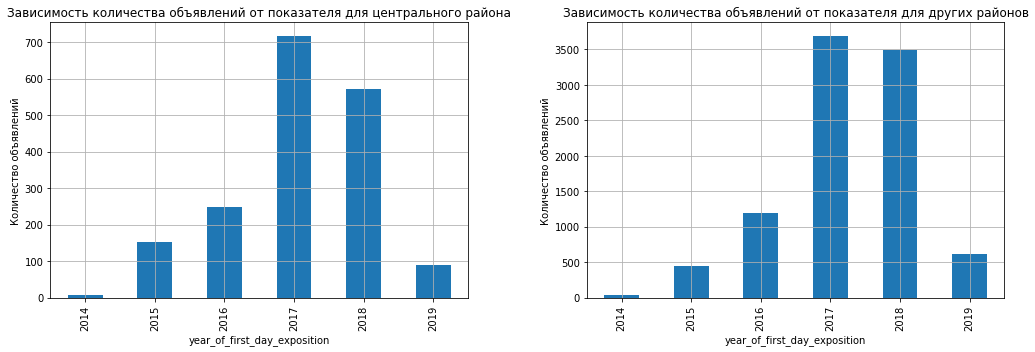

In [55]:
dict_count = ['week_day_of_first_day_exposition', 
             'month_of_first_day_exposition',
             'year_of_first_day_exposition']

for column in dict_count:
    f, ax = plt.subplots(1,2,  figsize = (15,5))
    pivot_table = good_table_Piter.query('center == 1').pivot_table(index=column, values='last_price_thous', aggfunc='count')
    pivot_table.plot(ax = ax[0], y = 'last_price_thous', legend = False, kind = 'bar', grid = True)
    ax[0].set_title('Зависимость количества объявлений от показателя для центрального района')
    ax[0].set_ylabel('Количество объявлений')
    ax[0].set_xlabel(column)
    
    pivot_table = good_table_Piter.query('center == 0').pivot_table(index=column, values='last_price_thous', aggfunc='count')
    pivot_table.plot(ax = ax[1], y = 'last_price_thous', legend = False, kind = 'bar', grid = True)
    ax[1].set_title('Зависимость количества объявлений от показателя для других районов')
    ax[1].set_ylabel('Количество объявлений')
    ax[1].set_xlabel(column)
    
    f.tight_layout()

**Вывод:** тенденции и в центральном районе, и в других районах Питера одинаковы, как и в других населенных пунктах:
* В основном объявления размещаются в будние дни, в выходные наблюдается значительный спад. 
* Чаще всего объявления размещаются к концу зимы (февраль), однако к маю наблюдается спад. Начиная с августа наблюдается равномерный рост количества объявлений, который оканчивается в ноябре (в декабре-январе наблюдается спад)
* Основной массив предоставленных данных относится к 2017-2018 гг.

***

## 4 Общий вывод

После проведения исследовательского анализа предоставленных данных можно сформулировтаь следующие выводы:
1. Рыночная стоимость объектов недвижимости в Санкт-Петербурге и соседних населённых пунктах за 2016-2018 гг. находится на уровне 3,5 млн руб. - 7 млн руб. При этом были обнаружены следующие зависимости:
    * чем больше площадь квартиры, тем дороже ее стоимость;
    * чем больше комнат в квартире, тем дороже ее стоимость;
    * квартиры на первом этаже дешевле, чем на остальных этажах;
    * чем дальше квартира от центра Санкт-Петербурга, тем она дешевле.
2. Наиболее дорогая недвижимость расположена в след. населенных пунктах: 
    * Санкт-Петербург
    * Пушкин
    * деревня Кудрово
    * посёлок Парголово 
    * посёлок Мурино
3. Наиболее дешевая недвижимость расположена в след. населенных пунктах: 
    * Выборг
    * Всеволожск
    * Гатчина
    * Колпино
    * посёлок Шушары
4. Стоимость квартиры в центре Санкт-Петербурга и в остальных его районах значительно отличаются: стоимость квартир в центральном районе находится в диапазоне от 4,5 млн руб. до 9 млн руб., в других районах - от 2,5 млн руб. до 6 млн руб.
5. Продажа квартиры с помощью сервиса Яндекс.Недвижимость обычно занимает от 1,5 мес. до 8 мес. (в среднем 3 месяца). 
6. Обнаружены следующие тенденции размещения объявлений по продаже квартир на сервисе Яндекс.Недвижимость:
    * в основном объявления размещаются по будням, в выходные наблюдается значительный спад. Это может быть связано с деятельностью различных агентов по недвижимости, которые активно работают в будние дни.
    * чаще всего объявления размещаются к концу зимы, однако к маю наблюдается спад (возможно, это связано с пасхальными и майскими праздниками, летними отпусками). Начиная с августа наблюдается равномерный рост количества объявлений, который оканчивается в ноябре (в декабре-январе наблюдается спад, скорее всего, в связи с новогодними праздниками)

Предлагается установить следующие параметры для отслеживание аномалий:
1. Высота потолков менее 2 м и более 6 м скорее всего является ошибочной.
2. Площадь квартиры более 150 м2 скорее всего ошибка.
3. Число комнат не может превышать 7.
4. Необходимо создать автоматический подсчет расстояния квартиры до центра города для избежания неточностей в данных.



